In [1]:
# Run this code block just once after the kernel starts
# to change current directory to root

import sys
import os

sys.path.append("..")
os.chdir("..")
print(os.getcwd())

/home/student/bev-project


In [2]:
from configs.config_utilities import load_config
from torch.utils.data import DataLoader

from models.pyramid import (
    build_pyramid_occupancy_network,
    build_extended_pyramid_occupancy_network,
)
from dataset import NuScenesDataset

In [3]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm


In [4]:
config = load_config("configs/configs.yml")

In [5]:
validate_dataset = NuScenesDataset(
    nuscenes_dir=config.nuscenes_dir,
    nuscenes_version=config.nuscenes_version,
    label_dir=config.label_dir,
    sample_tokens=config.val_tokens,
    image_size=(200, 112),
    flatten_labels=(config.method_type == "multiclass"),
)
validate_loader = DataLoader(
    validate_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    pin_memory=True,
    shuffle=False,
)

--------------------------------------------------
Loading NuScenes version v1.0-mini ...
--------------------------------------------------


In [6]:
import utilities.torch as torch_utils

device = torch_utils.detect_device()
print(device)

cuda


In [9]:
images, labels, masks, calibs = next(iter(validate_loader))

images = images.to(device)
labels = labels.to(device)
masks = masks.to(device)
calibs = calibs.to(device)

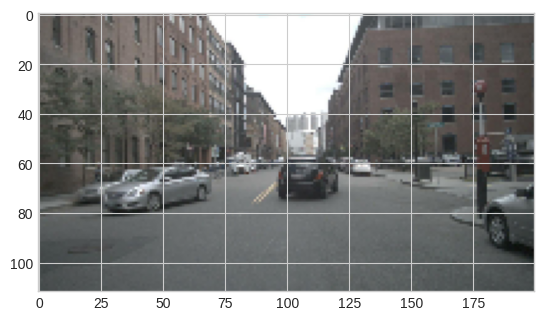

In [8]:
plt.imshow(images[0].cpu().permute(1,2,0))

In [11]:
network = build_extended_pyramid_occupancy_network(config).to(device)

/home/student/miniconda3/envs/senior_project/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
checkpoint_path = "checkpoints/Fixed_PON_V+H_multilabel_1693221123.702727_00499.pt"
checkpoint = torch.load(checkpoint_path)
network.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [24]:
_val_images = list()
_val_labels = list()
_val_masks = list()
_val_predictions = list()

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(validate_loader)):
        images, labels, masks, calibs = batch

        labels = labels.to(device)
        masks = masks.to(device)
        calibs = calibs.to(device)

        images = images.to(device)
        predictions = network(images, calibs).to(device)

        _val_images.append(images)
        _val_labels.append(labels)
        _val_masks.append(masks)
        _val_predictions.append(predictions)

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


In [25]:
val_images = torch.cat(_val_images, dim=0)
val_labels = torch.cat(_val_labels, dim=0)
val_masks = torch.cat(_val_masks, dim=0)
val_predictions = torch.cat(_val_predictions, dim=0)

In [36]:
val_labels[0].shape

torch.Size([14, 196, 200])

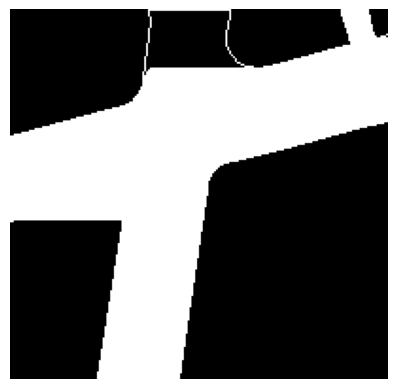

In [35]:
fig

plt.imshow(val_labels[0][0].cpu(), cmap="gray")
plt.axis("off")
plt.show()